In [1]:
import numpy as np
from data.MyDataSet import MyDataSet
from unet.unet_model import UNet
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import gc
from tqdm import tqdm

### Start Plot Server, Do not run this command at here

In [2]:
# !python -m visdom.server

In [5]:
def train_net(net, device, train_loader, optimizer, epochIdx, criterion, ACC_LIST, LOSS_LIST):
    net.train()
    total_loss = 0
    for image, target in train_loader:
        image, target = image.to(device=device, dtype=torch.float32), target.to(device=device, dtype=torch.float32)
        optimizer.zero_grad()
        # predict the output
        output = net(image)

        # calculate accuracy
        acc = cal_acc(output, target)
        ACC_LIST.append(acc)
        # print("Acc: ", acc)

        # calculate the loss
        loss = criterion(output, target)
        # print("Loss:  ", loss.item())
        LOSS_LIST.append(loss.item())

        # back forward to update parameters
        loss.backward()
        optimizer.step()
       
def cal_acc(pred, label):
    _, tags = torch.max(pred, dim = 1)
    corrects = (tags == label).float()
    acc = corrects.sum() / corrects.numel()
    acc = acc * 100
    return acc

In [6]:
gc.collect()
torch.cuda.empty_cache()
# prepare data set
trainSet = MyDataSet("./data/SDLane/train/", "./data/SDLane/train/train_list.txt")
# testSet = MyDataSet("./data/SDLane/test/", "./data/SDLane/test/test_list.txt")
train_loader = DataLoader(dataset=trainSet, batch_size=10, shuffle=True)
# test_loader = DataLoader(dataset=testSet, batch_size=50, shuffle=True)

In [7]:
# prepare net parameters
net = UNet(n_channels=1, n_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
# optimizer and loss function
optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

# train network
ACC_LIST = []
LOSS_LIST = []

train_net(net, device, train_loader, optimizer, 0, criterion, ACC_LIST, LOSS_LIST)
torch.save(net, "./model.mod")

In [27]:
import csv
with open('./record.csv','w') as f1:
    writer=csv.writer(f1, delimiter='\t',lineterminator='\n',)
    for i in range(len(ACC_LIST)):
        row = "{}, {}, {}".format(i, ACC_LIST[i].item(), LOSS_LIST[i])
        writer.writerow(row)


In [35]:
acces = []
indexes = []
for i in range(len(ACC_LIST)):
    acces.append(ACC_LIST[i].item())
    indexes.append(i)

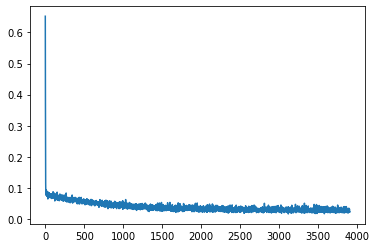

In [38]:
import matplotlib.pyplot as plt
plt.plot(indexes, LOSS_LIST)